In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

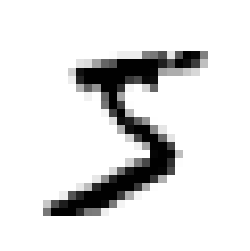

5

In [18]:
X_data = X.to_numpy()
digit = X_data[0]
digit_image = digit.reshape(28, 28)
plt.figure(figsize=(3, 3))
plt.imshow(digit_image, cmap = plt.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()
y[0]

In [17]:
y = y.astype(np.uint8)

In [22]:
X_train, X_test, y_train, y_test = X_data[:60000], X_data[60000:], y[:60000], y[60000:]

In [27]:
from sklearn.linear_model import SGDClassifier
y_train_5 = (y_train == 5) #assign 5 to test as binary classifier on just 5's
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [28]:
sgd_clf.predict([digit])

array([ True])

In [29]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.96355, 0.9665 , 0.9666 ])

In [33]:
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass 
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [35]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix
#compare actual labels agianst predicted labels 
confusion_matrix(y_train_5, y_train_pred)
#True positive - 53722, model correctly predicted the digit "5" 53,722 times.
#False Negative - 857, model incorrectly predicted "not 5" when it was actually "5".
#False Positives - 1385, model identified as 5 when they're non 5's
#True Negative - 4036, correctly predicted non 5's 

array([[53722,   857],
       [ 1385,  4036]], dtype=int64)

In [53]:
from sklearn.metrics import precision_score, recall_score 
# Precision measures the accuracy of positive predictions.
# tells us the proportion of true positive predictions (correctly predicted 5's) out of all positive predictions (all instances predicted as 5).
# In this case, when the model claims an image represents a '5', it is correct 82% of the time.
precision_score(y_train_5, y_train_pred) 

0.8248518291436746

In [54]:
# Recall measures the ability of the model to find all relevant instances (true positives).
# It tells us the proportion of true positive predictions (correctly predicted 5's) out of all actual positive instances (all actual 5's in the dataset).
# Here, the model detects only 74% of the actual 5's present in the dataset.
recall_score(y_train_5, y_train_pred) 

0.7445120826415791

In [58]:
from sklearn.metrics import f1_score #harmonic mean of precision and recall. more weight to lower values.
f1_score(y_train_5, y_train_pred)

0.7826255574946676

In [70]:
y_scores = sgd_clf.decision_function([digit])
y_scores #strong confidence that the input digit belongs to positive class

array([2285.94546853])

In [73]:
threshold = 2200 #input level to determine decision scores and class membership
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

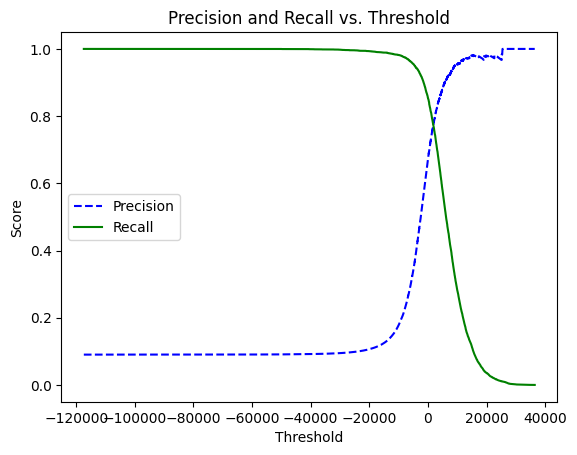

<Figure size 400x400 with 0 Axes>

In [96]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Threshold")
    plt.legend()  

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.figure(figsize=(4, 4))
plt.show()

In [97]:
threshold_90_prediction = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_prediction)
precision_score(y_train_5, y_train_pred_90)

0.9000939555277169

In [98]:
recall_score(y_train_5, y_train_pred_90)

0.5301604869950194

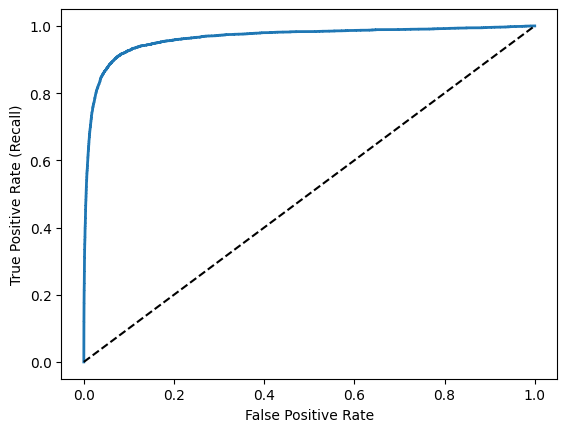

<Figure size 500x500 with 0 Axes>

In [110]:
from sklearn.metrics import roc_curve #measures true positive rate vs. false positive rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    
plot_roc_curve(fpr, tpr, thresholds)
plt.figure(figsize = (5, 5))
plt.show()

In [112]:
from sklearn.metrics import roc_auc_score 
#single scalar value that summarizes the performance of the model across all thresholds
#0.5 indicates a model with no discrimination capability (equivalent to random guessing)
#1.0 indicates a perfect model that perfectly separates the classes.
roc_auc_score(y_train_5, y_scores)

0.9641484027260515

In [115]:
from sklearn.ensemble import RandomForestClassifier
#predict_proba() method returns an array containing a row per instance and a column per class, 
#each containing the probability that the given instance belongs to the
# given class (e.g., 70% chance that the image represents a 5)
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')

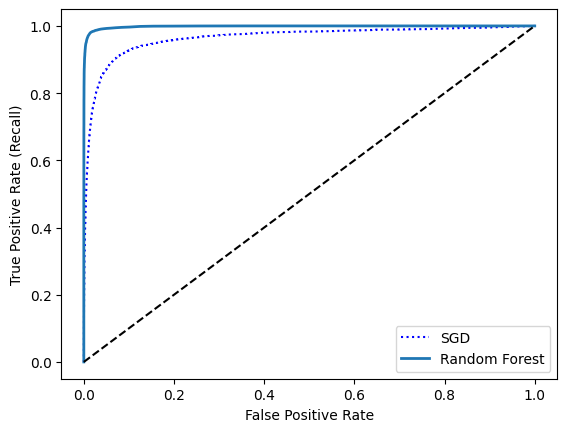

In [119]:
#use positive class's probability as score 
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = 'lower right')
plt.show()
#Random Forest looks better - comes closer to the top-left corner. 

In [120]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

MultiClass Classification

In [123]:
sgd_clf = sgd_clf.fit(X_train, y_train) #y train, not y_train_5 - makes it multiclass vs. binary
sgd_clf.predict([digit])

array([5], dtype=uint8)

In [132]:
#under the hood, 10 binary classifiers were trained, decision scores were computed for the each image
#e.g. 1 - detector, 2 - detector, 3 - detector
#and class with highest score was selected
#OvA strategy
digit_scores = sgd_clf.decision_function([digit])
digit_scores 

array([[-33663.44533265, -52614.95864375,  -6879.76638727,
           356.12624454, -21061.44956702,   3778.45425582,
        -32016.59541976, -19403.53107093,  -9023.87309337,
         -6669.9854646 ]])

In [130]:
print(np.argmax(digit_scores)) #highest score is class 5
print(sgd_clf.classes_)

5
[0 1 2 3 4 5 6 7 8 9]


In [135]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
#train binary classifier for every pair of digits, e.g. one to distinguish 0s and 1s, 
#one for 1s and 2s.. #OvO strategy
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([digit])

array([5], dtype=uint8)

In [137]:
len(ovo_clf.estimators_) #45 classes for OneVsOneClassifier

45

In [138]:
forest_clf.fit(X_train, y_train) #Random Forest classifiers can directly classify instances into multiple classes
forest_clf.predict([digit])

array([5], dtype=uint8)

In [139]:
forest_clf.predict_proba([digit]) #get list of probabiltiies that classifier assigned to each instance for each class. 0.9 at index 5 - 90% probability that img = 5

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [140]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84455, 0.8672 , 0.88135])

In [141]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.89985, 0.8919 , 0.89815])

Error Analysis

In [142]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5574,    0,   21,    5,    8,   43,   34,    5,  232,    1],
       [   0, 6405,   37,   24,    4,   43,    4,    8,  205,   12],
       [  28,   27, 5230,   91,   71,   25,   67,   38,  374,    7],
       [  23,   18,  115, 5224,    1,  203,   26,   39,  412,   70],
       [  12,   14,   46,    9, 5186,   12,   34,   26,  344,  159],
       [  27,   16,   30,  167,   51, 4436,   74,   14,  543,   63],
       [  29,   16,   44,    2,   43,   98, 5551,    3,  131,    1],
       [  20,    9,   51,   26,   47,   12,    3, 5699,  192,  206],
       [  18,   64,   48,   92,    3,  121,   24,   10, 5431,   40],
       [  20,   18,   30,   64,  117,   35,    1,  180,  382, 5102]],
      dtype=int64)

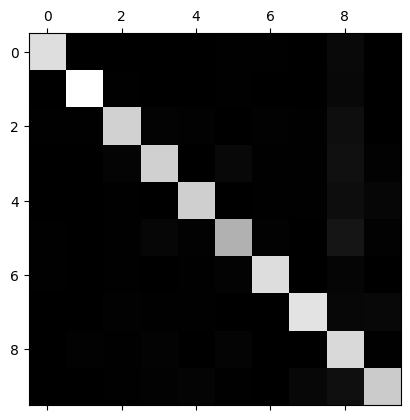

In [143]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

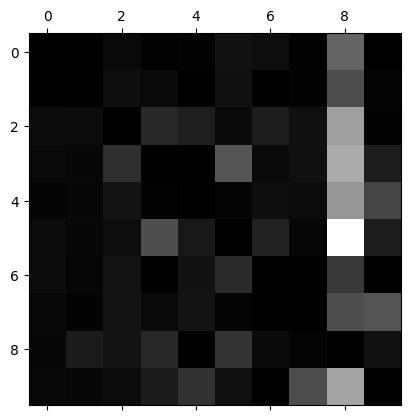

In [145]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()
#rows represent actual classes, cols represent predicted classes
#column for 8 is bright - many images get misclassified as 8s.. 
#rows for class 8 is ok - actual 8's in general get properly classified

Multilabel Classification

In [150]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #whether or not digit is large (7, 8, 9)
y_train_odd = (y_train % 2 == 1) #whether or not digit is odd
y_multilabel = np.c_[y_train_large, y_train_odd] #converge into a multilabel array

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [159]:
print(y[0])
knn_clf.predict([digit]) #5 is not large, but is odd

5


array([[False,  True]])

In [160]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [163]:
#Multioutput classification 

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[digit]])
plot_digit(clean_digit)


IndexError: arrays used as indices must be of integer (or boolean) type